sog translation site analysis 01.25

@author: jennifer love

This script analyses the translation output of sog mRNAs across its expression domain using the SunTag method. Colocalised mRNAs and neongreen (protein) foci represent active sites of translation, and the total intensity of active translation sites per nucleus is calculated to give a readout of sog translation across the domain.

The data used here have undergone pre-processing including colocalisation of mRNAs and neongreen foci (via Imaris), and colocalised neongreen foci have been assigned to the closest nucleus using the sass pipeline. See paper methods for further details.

In [1]:
# Import packages and set global plotting parameters

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math as math
from cmcrameri import cm

mpl.rc('font',family='Arial', size=16)
csfont = {'fontname': 'Arial'}
sns.rc={'axes.facecolor':'white', 'figure.facecolor':'white'}


Define functions to be used in this script

In [2]:
def plot_heatmap(x, y, size, colors, xtitle, ytitle, savefig):
    fig, ax = plt.subplots(figsize=size)
    
    sns.scatterplot(x=x, y=y, hue=colors, palette=cm.navia, s=50, edgecolor=None)
    ax.set_xlabel(xtitle, size=14)
    ax.set_ylabel(ytitle, size=14)
    ax.grid(False)
    ax.set_facecolor('white')
    ax.axis('on')
    ax.spines['left'].set_color('k')
    ax.spines['right'].set_color('k')
    ax.spines['top'].set_color('k')
    ax.spines['bottom'].set_color('k')
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    if savefig == 'true':
        plt.savefig('e1_heatmap.png', dpi=1200)
    plt.show()

def rotate_embryo(data, x, y, theta, AP_flip, DV_flip):
    data['xrot'] = (x * math.cos(theta)) - (y * math.sin(theta))
    data['yrot'] = (x * math.sin(theta)) + (y * math.cos(theta))
    if AP_flip == 'true':
        data['xrot'] = - data['xrot']
    if DV_flip == 'true':
        data['yrot'] = - data['yrot']
    return data

def normalise_data_2D(data, colx, coly, subscript_x='', subscript_y=''):
    data['xnorm' + subscript_x] = ((colx- colx.min())/(colx.max() - colx.min()))
    data['ynorm' + subscript_y] = ((coly - coly.min())/(coly.max() - coly.min()))
    return data

def bin_data(data, col, bins, bin_name):
    bin_step = 1/bins
    count = 1
    for i in np.arange(0,1, bin_step):
        if i == 0:
            data.loc[col.between(i, (i+bin_step), 'both'), bin_name] = count
        else:
            data.loc[col.between(i, (i+bin_step), 'right'), bin_name] = count
        count = count + 1
    return data

Import neongreen foci position and intensity data and inspect the data

In [ ]:
# position data
neongreen_coloc_positions = pd.read_csv('', engine='python', header=0)
neongreen_coloc_positions = neongreen_coloc_positions[neongreen_coloc_positions.columns[0:3]]
neongreen_coloc_positions.columns = ['proteinx', 'proteiny', 'proteinz']
print(neongreen_coloc_positions)

# intensity data
neongreen_coloc_intensities = pd.read_csv('', engine='python', header=0)
neongreen_coloc_intensities = neongreen_coloc_intensities[neongreen_coloc_intensities.columns[0:1]]
neongreen_coloc_intensities.columns = ['intensity_sum']
print(neongreen_coloc_intensities)

# create a larger dataframe with all data
frames = [neongreen_coloc_positions, neongreen_coloc_intensities]
neongreen_coloc = pd.concat(frames, axis=1)
print(neongreen_coloc)

Background correct the data

In [ ]:
# read in background intensity data and calculate average BG
background_spot_intensities = pd.read_csv('', engine='python', header=0)
background_spot_intensities.columns = ['intensity_sum']
print(background_spot_intensities)

boxplot = background_spot_intensities.boxplot(column=['intensity_sum'])

mean_bg = background_spot_intensities['intensity_sum'].mean()
median_bg = background_spot_intensities['intensity_sum'].median()

print(mean_bg)
print(median_bg)

# background correct intensity data
neongreen_coloc['intensity_sum'] = neongreen_coloc['intensity_sum'] - median_bg
neongreen_coloc = neongreen_coloc[neongreen_coloc['intensity_sum'] > 0]
print(neongreen_coloc)

In [ ]:
# visualise the data to work out angles to rotate and flip below
plot = sns.scatterplot(x = neongreen_coloc.proteinx, y = neongreen_coloc.proteiny, hue = neongreen_coloc.intensity_sum)

Rotate data to correctly orient embryo in AP and DV (user to define angle and whether flipping is necessary)

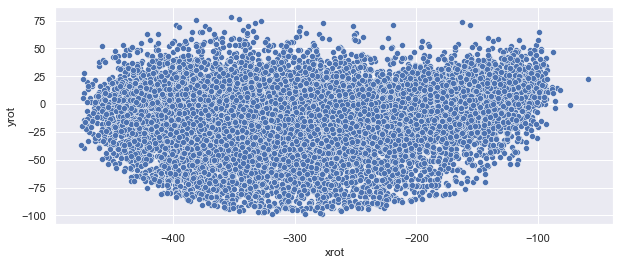

In [ ]:
degrees_to_rotate = -45 # change this depending on graph above (angle in degrees)
flip_embryo_in_AP = 'true' # change this to false if it doesn't need flipping in AP 'true' OR 'false'
flip_embryo_in_DV = 'true' # change this to false if it doesn't need flipping in DV 'true' OR 'false'

# rotate data
rotated_data = rotate_embryo(neongreen_coloc, neongreen_coloc.proteinx, neongreen_coloc.proteiny, np.radians(degrees_to_rotate), flip_embryo_in_AP , flip_embryo_in_DV)

# visualise data correctly oriented (hopefully)
sns.set_theme(rc={'figure.figsize':(10,4)})
plot = sns.scatterplot(x = rotated_data.xrot, y = rotated_data.yrot)

Import neongreen foci assigned to closest nucleus (output from spotMe script)

In [ ]:
# import data with foci assigned to nuclei
ng_per_nucleus = pd.read_csv('', engine='python', header=0)
ng_per_nucleus = ng_per_nucleus.drop(columns=['spot', 'Unnamed: 0'])
print(ng_per_nucleus)

# merge with positional and intensity data from above
total_data = pd.merge(neongreen_coloc, ng_per_nucleus,  how='left', left_on=['proteinx','proteiny', 'proteinz'], right_on = ['x','y', 'z'])
print(total_data)

       nuc  num_spots         x        y         z     nuc_x     nuc_y  \
0     1999        8.0   96.1882  68.8843  0.964935   94.5017   70.2237   
1     1999        8.0   91.4576  71.3773  1.029960   94.5017   70.2237   
2     1963        7.0  109.0000  73.2514  0.800661  108.3120   72.8387   
3     2070        6.0   95.3810  42.2269  1.236690   94.4019   43.8480   
4     2070        6.0   93.8830  46.1834  1.090430   94.4019   43.8480   
...    ...        ...       ...      ...       ...       ...       ...   
9788  1108        0.0       NaN      NaN       NaN  247.0550  138.3120   
9789  1121        0.0       NaN      NaN       NaN  254.6810  118.1670   
9790  1125        0.0       NaN      NaN       NaN  250.2220  127.1100   
9791  1127        0.0       NaN      NaN       NaN  254.4900  124.3960   
9792  1129        0.0       NaN      NaN       NaN  248.2580  131.3430   

        nuc_z  
0     4.10831  
1     4.10831  
2     4.53922  
3     4.23586  
4     4.23586  
...       ...  

Determine total intensity of neongreen foci per nucleus

In [ ]:
# sum the total intensity of all neongreen foci in a single nucleus

summed_intensity_per_nuc = total_data.groupby('nuc')['intensity_sum'].sum()
summed_intensity_per_nuc = pd.DataFrame(summed_intensity_per_nuc)
summed_intensity_per_nuc.reset_index(inplace=True)
summed_intensity_per_nuc.columns = ['nuc', 'intensity_sum_per_nuc']

total_data = pd.merge(total_data, summed_intensity_per_nuc,  how='left', on='nuc')
total_data = total_data.drop(columns=['proteinx', 'proteiny', 'proteinz', 'intensity_sum', 'xrot', 'yrot', 'num_spots', 'x', 'y', 'z'])
total_data.drop_duplicates(inplace=True)

ng_per_nucleus = ng_per_nucleus.drop(columns=['x', 'y', 'z'])
ng_per_nucleus.drop_duplicates(inplace=True)

# merge back to all nuclei to include those with no neongreen foci 
total_data = pd.merge(ng_per_nucleus, total_data,  how='left', on=['nuc', 'nuc_x', 'nuc_y', 'nuc_z'])
total_data['intensity_sum_per_nuc'] = total_data['intensity_sum_per_nuc'].fillna(0)
print(total_data)

       nuc  num_spots     nuc_x     nuc_y    nuc_z  intensity_sum_per_nuc
0     1999        8.0   94.5017   70.2237  4.10831               7997.729
1     1963        7.0  108.3120   72.8387  4.53922               7538.245
2     2070        6.0   94.4019   43.8480  4.23586               4098.408
3     2102        2.0   89.7064   44.3125  4.24215               1777.197
4     2093        2.0   93.0966   38.2597  3.78252               2367.323
...    ...        ...       ...       ...      ...                    ...
2245  1108        0.0  247.0550  138.3120  5.49782                  0.000
2246  1121        0.0  254.6810  118.1670  8.65182                  0.000
2247  1125        0.0  250.2220  127.1100  5.08191                  0.000
2248  1127        0.0  254.4900  124.3960  6.64068                  0.000
2249  1129        0.0  248.2580  131.3430  5.07960                  0.000

[2250 rows x 6 columns]


Rotate and normalise the nuclear data (to correctly orient embryo in AP and DV)

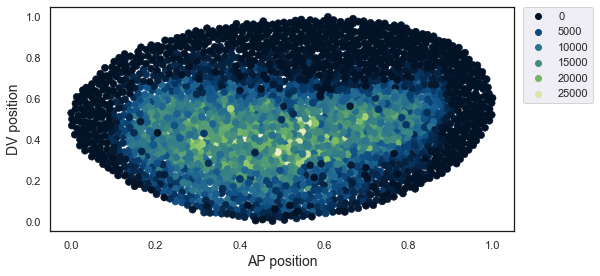

In [ ]:
# rotate data to correctly orient in AP (as above but for the nuclear summed data)
rotated_data_nuc = rotate_embryo(total_data, total_data.nuc_x, total_data.nuc_y, np.radians(degrees_to_rotate), flip_embryo_in_AP , flip_embryo_in_DV)

# normalise data and plot heatmap of total ng intensity per nucleus across whole embryo
rotated_data_nuc_normalised = normalise_data_2D(rotated_data_nuc, rotated_data_nuc['xrot'], rotated_data_nuc['yrot'])
plot = plot_heatmap(rotated_data_nuc_normalised.xnorm, rotated_data_nuc_normalised.ynorm, (8.5,4), rotated_data_nuc_normalised.intensity_sum_per_nuc, 'AP position', 'DV position','true') # change to false if not saving fig

Crop the data between 0.2 and 0.8 along the AP axis before binning and averaging across the DV axis

In [ ]:
# crop in AP
rotated_data_nuc_normalised_cropped_AP = rotated_data_nuc_normalised[rotated_data_nuc_normalised.xnorm > 0.2]
rotated_data_nuc_normalised_cropped_AP = rotated_data_nuc_normalised_cropped_AP[rotated_data_nuc_normalised_cropped_AP.xnorm < 0.8]

# bin data in DV
ng_binned_DV = bin_data(rotated_data_nuc_normalised_cropped_AP, rotated_data_nuc_normalised_cropped_AP['ynorm'], 12, 'DVBin')
ng_binned_DV['DVBin'] = ng_binned_DV['DVBin'].apply(lambda x: math.floor(x))
print(ng_binned_DV)

# output summary table of means and stdev
output = ng_binned_DV.groupby(['DVBin'], as_index=False).agg({'intensity_sum_per_nuc':['mean','std']})
print(output)

       nuc  num_spots    nuc_x     nuc_y    nuc_z  intensity_sum_per_nuc  \
54    1908        8.0  117.931   75.1980  4.30006               8167.149   
55    1816        5.0  140.398   82.0943  5.10758               4139.421   
58    1848        8.0  121.023   82.2884  4.92761               9692.157   
59    1861        7.0  124.893   80.1023  3.95211               5898.927   
60    1819        5.0  136.693   85.9082  5.43363               6141.785   
...    ...        ...      ...       ...      ...                    ...   
2245  1108        0.0  247.055  138.3120  5.49782                  0.000   
2246  1121        0.0  254.681  118.1670  8.65182                  0.000   
2247  1125        0.0  250.222  127.1100  5.08191                  0.000   
2248  1127        0.0  254.490  124.3960  6.64068                  0.000   
2249  1129        0.0  248.258  131.3430  5.07960                  0.000   

            xrot       yrot     xnorm     ynorm  DVBin  
54   -136.562826  30.216794  0

Plot the mean ng intensity per nucleus in 12 bins across the DV axis

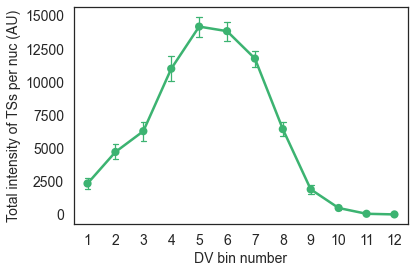

In [ ]:
# plot the mean +/- sem neongreen intensity per nucleus in bins across the DV axis

sns.set_theme(rc={'figure.figsize':(6,4)})
sns.set_theme(rc={"lines.linewidth": 0.7})
sns.set_style(style='white')
ax = sns.pointplot(x=ng_binned_DV.DVBin, y=ng_binned_DV.intensity_sum_per_nuc, color='mediumseagreen', scale=2, capsize=0.2)
ax.grid(False)
ax.set_xlabel('DV bin number', size=14)
ax.set_ylabel('Total intensity of TSs per nuc (AU)', size=14)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('e1_bin_plot.png', dpi=1200) # comment out if not saving fig